<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/pf_guided_neural_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Particle filtering for neural decoding (SSM with Poisson likelihood)

Code is from 
https://github.com/nchopin/particles/blob/master/book/filtering/neurodecoding.py


In [1]:
!git clone https://github.com/nchopin/particles.git


Cloning into 'particles'...
remote: Enumerating objects: 1506, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (416/416), done.
remote: Total 1506 (delta 445), reused 472 (delta 257), pack-reused 816
Receiving objects: 100% (1506/1506), 4.48 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (968/968), done.


In [3]:
!ls

particles  sample_data


In [13]:
%cd /content/particles

/content/particles


In [14]:
!ls

book	   _config.yml	    docs     LICENSE  particles  requirements.txt
CHANGELOG  CONTRIBUTING.md  INSTALL  papers   README.md  setup.py


In [15]:
!pip install --user .


Processing /content/particles
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 28.5 MB 69 kB/s 
  Created wheel for particles: filename=particles-0.2-py3-none-any.whl size=573163 sha256=346752402d7ed41e9dd9018176f6214931524f8dbd085559d119cbb25e54a978
  Stored in directory: /tmp/pip-ephem-wheel-cache-1189sjxk/wheels/c4/ec/4d/9651be18bff1d8c3beaff376421029d3d43569a79306f8a862
Successfully built particles
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires i

In [1]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists



In [3]:
#%run /content/particles/book/filtering/neurodecoding.py

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:216: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


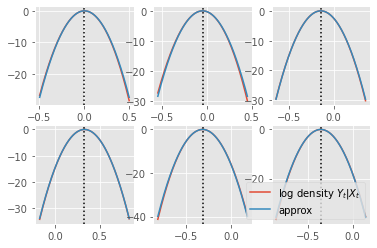

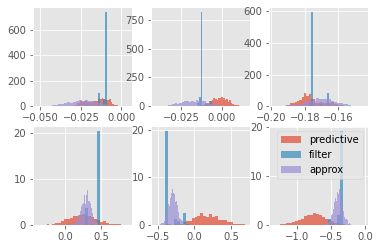

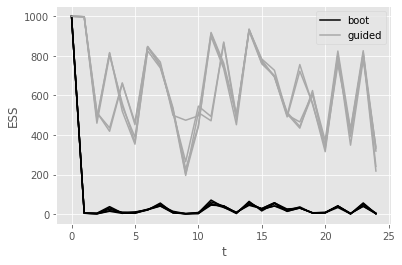

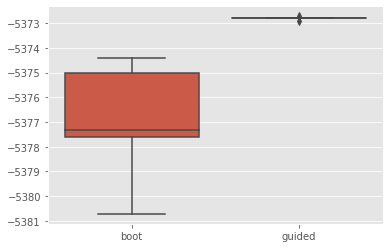

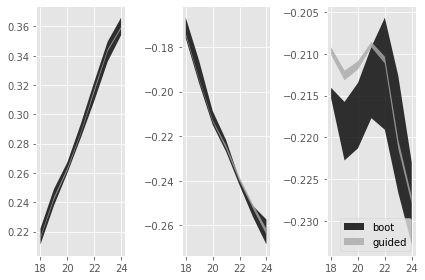

In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""Third numerical experiment of Chapter 10 (Particle filtering).
Compare bootstrap and guided filters on a neuro-decoding state-space model,
taken from Koyama et al (2010).
The proposal of the guided filter is based on a Gaussian approximation of the
density x_t --> log f_t(y_t|x_t), obtained by Newton-Raphson.
See Section 10.4.3 and Figures 10.4-10.5 in the book for a discussion.
"""
from __future__ import division, print_function

from collections import OrderedDict
import numpy as np
from numpy import random
from scipy import linalg
from matplotlib import pyplot as plt
import seaborn as sb

import particles
from particles import distributions as dists
from particles import kalman
from particles import state_space_models as ssms
from particles.collectors import Moments

class NeuralDecoding(ssms.StateSpaceModel):
    """
    X_t is position (3D) plus velocity (3D); in each dimension,
    {X_t(i), X_t(i+3)} is a discretized integrated Brownian motion, i.e.
    X_t(i) = X_{t-1}(i) + X_{t-1}(i+3) + tau * U_t(i) for i=1, 2, 3
    X_t(i) = X_{t-1}(i) + tau * V_t(i) for i=4, 5, 6
    with ( U_t(i) )  ~  N_2( (0), (delta^3/3  delta^2/2) )
         ( V_t(i) )        ( (0)  (delta^2/2  delta    ) )
    Y_t|X_t=x is a vector of size dy, such that
    Y_t(k) ~ Poisson( exp(a[k]+b[k]*x) )
    """
    dx = 6

    def __init__(self, delta=0.01, tau=0.3, a=None, b=None, x0=None):
        #a is a vector of size dy, b is a dy*dx array
        self.delta = delta; self.tau = tau
        self.a = a; self.b = b; self.x0 = x0
        self.SigX = np.diag(np.concatenate((np.full(3, delta**3 / 3),
                                            np.full(3,delta))))
        for i in range(3):
            self.SigX[i, i+3] = 0.5 * delta**2
            self.SigX[i+3, i] = 0.5 * delta**2
        self.SigX = tau**2 * self.SigX

    @property
    def dy(self):
        return self.a.shape[0]

    def predmean(self, xp):
        """ Expectation of X_t given X_{t-1}=xp
        """
        out = np.empty_like(xp)
        for i in range(3):
            out[:, i] = xp[:, i] + self.delta * xp[:, i+3]  # position
            out[:, i+3] = xp[:, i+3]                      # velocity
        return out

    def PX0(self):
        return dists.IndepProd(*[dists.Dirac(loc=self.x0[i])
                                 for i in range(6)])

    def PX(self, t, xp):
        return dists.MvNormal(loc=self.predmean(xp), cov=self.SigX)

    def PY(self, t, xp, x):
        return dists.IndepProd(*[dists.Poisson(np.exp(self.a[k] +
                                                      np.sum(x*self.b[k], axis=1)))
                                 for k in range(self.dy)])

    def diff_ft(self, xt, yt):
        """First and second derivatives (wrt x_t) of log-density of Y_t|X_t=xt
        """
        a, b = self.a, self.b
        ex = np.exp(a + np.matmul(b, xt))  # shape = (dy,)
        grad = (-np.sum(ex[:, np.newaxis] * b, axis=0)
                + np.sum(yt.flatten()[:, np.newaxis] * b, axis=0))
        hess = np.zeros((self.dx, self.dx))
        for k in range(self.dy):
            hess -= ex[k] * np.outer(b[k,:], b[k,:])
        return grad, hess

    def approx_likelihood(self, yt):
        """ Gaussian approx of x_t --> f_t(y_t|x_t)
        """
        x = np.zeros(self.dx)
        max_nb_attempts = 100
        tol = 1e-3
        for i in range(max_nb_attempts):
            grad, hess = self.diff_ft(x, yt)
            xnew = x - linalg.solve(hess, grad)  # Newton Raphson
            if linalg.norm(xnew - x, ord=1) < tol:
                break
            x = xnew
        return (x, -hess)

    def approx_post(self, xp, yt):
        """ approximates the law of X_t|Y_t,X_{t-1}
        returns a tuple of size 3: loc, cov, logpyt
        """
        xmax, Q = self.approx_likelihood(yt)
        G = np.eye(self.dx)
        covY = linalg.inv(Q)
        pred = kalman.MeanAndCov(mean=self.predmean(xp), cov=self.SigX)
        return kalman.filter_step(G, covY, pred, xmax)

    def proposal(self, t, xp, data):
        filt, _ = self.approx_post(xp, data[t])
        return dists.MvNormal(loc=filt.mean, cov=filt.cov)

    def proposal0(self, data):
        return self.PX0()

    def logeta(self, t, x, data):
        _, logpyt = self.approx_post(x, data[t+1])
        # when running the APF, the approx is computed twice
        # not great, but expedient
        return logpyt

# parameters
dy = 80  # number of neurons
dx = 6 # 3 for position, 3 for velocity
T = 25
a0 = random.normal(loc=2.5, size=dy)  # from Koyama et al
# the b's are generated uniformly on the unit sphere in R^6 (see Koyama et al)
b0 = random.normal(size=(dy, dx))
b0 = b0 / (linalg.norm(b0, axis=1)[:, np.newaxis])
delta0 = 0.03; tau0 = 1.
x0 = np.zeros(dx)

# models
chosen_ssm = NeuralDecoding(a=a0, b=b0, x0=x0, delta=delta0, tau=tau0)
_, data = chosen_ssm.simulate(T)
models = OrderedDict()
models['boot'] = ssms.Bootstrap(ssm=chosen_ssm, data=data)
models['guided'] = ssms.GuidedPF(ssm=chosen_ssm, data=data)
# models['apf'] = ssms.AuxiliaryPF(ssm=chosen_ssm, data=data)
# Uncomment this if you want to include the APF in the comparison

#N = 10**4; nruns = 50
N = 10**3; nruns = 5

results = particles.multiSMC(fk=models, N=N, nruns=nruns, nprocs=1,
                             collect=[Moments], store_history=True)

## PLOTS
#########
savefigs = True  # False if you don't want to save plots as pdfs
plt.style.use('ggplot')

# arbitrary time
t0 = 9

# check Gaussian approximation is accurate
plt.figure()
mu, Q  = chosen_ssm.approx_likelihood(data[t0])
lG = lambda x: models['boot'].logG(t0, None, x)
lGmax = lG(mu[np.newaxis, :])
for i in range(6):
    plt.subplot(2, 3, i+1)
    xt = np.repeat(mu[np.newaxis,:], N, axis=0)
    xt[:,i] = xt[:,i] + np.linspace(-0.5, 0.5, N)

    plt.plot(xt[:,i], lG(xt) - lGmax, label=r'log density $Y_t|X_t$')
    plt.plot(xt[:,i], -0.5 * Q[i,i] * (xt[:,i] - mu[i])**2, label='approx')
    plt.axvline(x=mu[i], ls=':', color='k')
plt.legend()

# check proposal
plt.figure()
pf = results[0]['output']
nbins = 30
X = pf.hist.X[t0]
Xp = pf.hist.X[t0 - 1]
proposed_rvs = chosen_ssm.proposal(t0, Xp, data).rvs(size=N)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(X[:,i], nbins, label='predictive', density=True, alpha=0.7)
    plt.hist(X[:,i], nbins, weights=pf.hist.wgts[t0].W, label='filter',
             density=True, alpha=0.7)
    plt.hist(proposed_rvs[:, i], nbins, label='approx', density=True, alpha=0.7)
plt.legend()

# ESS vs time
colors = {'boot':'black', 'guided':'darkgray', 'apf':'lightgray'}
plt.figure()
for r in results:
    if r['run']==0:
        plt.plot(r['output'].summaries.ESSs, color=colors[r['fk']],
                 label=r['fk'])
    else:
        plt.plot(r['output'].summaries.ESSs, color=colors[r['fk']])
plt.legend()
plt.xlabel('t')
plt.ylabel('ESS')
if savefigs:
    plt.savefig('neuro_ESS_vs_time.pdf')

# box-plots log-likelihood
plt.figure()
sb.boxplot(x=[r['fk'] for r in results],
           y=[r['output'].summaries.logLts[-1] for r in results])

# filtering expectation vs time
k = 7  # plot range T-k:T
range_t = range(T - k, T)
plt.figure()
for mod in models:
    est = np.array([ [avg['mean'] for avg in r['output'].summaries.moments]
                     for r in results if r['fk']==mod])
    for i in range(3):  # only the positions
        plt.subplot(1, 3, i+1)
        plt.fill_between(range_t, np.percentile(est[:, range_t, i], 25, axis=0),
                            np.percentile(est[:, range_t, i], 75, axis=0),
                            label=mod, alpha=0.8, facecolor=colors[mod])
        plt.xticks(range(T - k, T, 2))
plt.legend(loc=4)
plt.tight_layout()
if savefigs:
    plt.savefig('neuro_filt_expectation.pdf')

plt.show()